## Setting up the Environment

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from datetime import datetime

## Obtain the train and test data

In [ ]:
train = pd.read_csv("DataSet/train.csv")
test = pd.read_csv("DataSet/test.csv")

In [ ]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]','')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns =columns

train_float = train.copy()

train_float.loc[(train_float['Activity'] == 'STANDING')] = 0
train_float.loc[(train_float['Activity'] == 'SITTING')] = 1
train_float.loc[(train_float['Activity'] == 'LAYING')] = 2
train_float.loc[(train_float['Activity'] == 'WALKING')] = 3
train_float.loc[(train_float['Activity'] == 'WALKING_DOWNSTAIRS')] = 4
train_float.loc[(train_float['Activity'] == 'WALKING_UPSTAIRS')] = 5

In [ ]:
y_train = train.Activity
y_train_float = train_float.Activity
X_train = train.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['subject', 'Activity'], axis=1)

In [ ]:
labels=['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

## Obtaining our own Data

In [2]:
processed = pd.read_csv("Processed_DataSet/ProcessedData.csv")

first = processed.columns[0]
processed = processed.drop(first,axis=1)

# for col in processed.columns:
#     processed[col] = processed[col].fillna(-1)
    
# processed.replace([np.inf], 10.0)
# processed.replace([-np.inf], -10.0)

print("No of NAN in processed: {}".format(processed.isnull().values.sum()))
# print("No of inf in processed: {}".format())

train, test = train_test_split(processed, test_size=0.3, shuffle=True)

y_train = train.Activity
X_train = train.drop(['Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['Activity'], axis=1)


No of NAN in processed: 0


In [3]:
labels=['Cycling', 'Football', 'Jogging', 'JumpRope', 'Pushups']

In [4]:
print("No of dublicates in train: {}".format(sum(train.duplicated())))
print("No of dublicates in test: {}".format(sum(test.duplicated())))

No of dublicates in train: 171
No of dublicates in test: 63


## Modelling Data

### Setting up the Confusion Matrix

In [5]:
# function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [6]:
# generic function to run any model specified
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, print_cm=True, cm_map=plt.cm.Greens):
    # to store results at various phases
    results = dict()
    
    # time at which model starts training
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print("Done\n\n")
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done\n\n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing_time(HH:MM:SS.ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('-----------------------')
    print('|       Accuracy      |')
    print('-----------------------')
    print('\n      {}\n\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('-----------------------')
        print('|   Confusion Matrix  |')
        print('-----------------------')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap=cm_map)
    plt.show()
    
    # get classification report
    print('-----------------------------')
    print('|   Classification Report   |')
    print('-----------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results

In [7]:
# function to print the gridsearch Attributes
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('-----------------------')
    print('|    Best Estimator   |')
    print('-----------------------')
    print('\n\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while performing grid search
    print('-----------------------')
    print('|   Best Parameters   |')
    print('-----------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))
    
    # number of cross validation splits
    print('--------------------------------')
    print('|  No of CrossValidation sets  |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('-----------------------')
    print('|      Best Score     |')
    print('-----------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))
        

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

## K-Nearest Neighbours

In [ ]:
# knn_params = {'n_neighbors':[2, 3, 4, 5, 6, 7]} # k = 7 (90.2%)
knn_params = {'n_neighbors':[11, 13, 15, 17, 19], 'weights': ['uniform','distance'], 'algorithm': ['ball_tree', 'kd_tree','brute']}
knn_kernel = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(knn_kernel, param_grid=knn_params, n_jobs=-1, verbose=1)
knn_grid_results = perform_model(knn_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
print_grid_search_attributes(knn_grid_results['model'])

In [ ]:
best_kernel_knn = neighbors.KNeighborsClassifier(n_neighbors=17, weights="distance", algorithm="ball_tree")
best_svm_results = perform_model(best_kernel_knn, X_train, y_train, X_test, y_test,class_labels=labels)

## SVC

### Linear

In [ ]:
# lr_params = {'C':[0.125, 0.5, 1, 2, 8, 16]} # best param 0.5 (0.962)
lr_params = {'C':[0.25, 0.3, 0.5, 0.7, 0.8]} # best param 0.5 (0.963)
lr_kernel = svm.SVC(kernel='linear')
lr_svc_grid = GridSearchCV(lr_kernel, param_grid=lr_params, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
print_grid_search_attributes(lr_svc_grid_results['model'])

### Radial Basis Function

training the model..
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Done


training_time(HH:MM:SS.ms) - 0:00:57.446104


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.259293


-----------------------
|       Accuracy      |
-----------------------

      0.8679631525076765


-----------------------
|   Confusion Matrix  |
-----------------------

 [[167  23   0   3   1]
 [ 23 541   5  12   0]
 [  1  11   6   2   0]
 [ 14  23   1 118   1]
 [  4   0   0   5  16]]


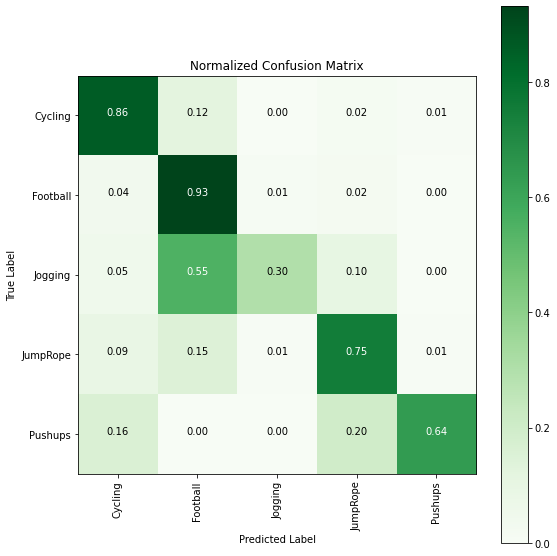

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.80      0.86      0.83       194
    Football       0.90      0.93      0.92       581
     Jogging       0.50      0.30      0.37        20
    JumpRope       0.84      0.75      0.79       157
     Pushups       0.89      0.64      0.74        25

    accuracy                           0.87       977
   macro avg       0.79      0.70      0.73       977
weighted avg       0.87      0.87      0.86       977



In [9]:
rbf_kernel = svm.SVC(kernel='rbf')
rbf_params = {'C':[55, 60, 65, 81, 90], 'gamma':['scale', 0.01, 0.03, 0.05, 0.07]}
rbf_svc_grid = GridSearchCV(rbf_kernel, param_grid=rbf_params, n_jobs=-1, verbose=1)
rbf_svc_grid_results = perform_model(rbf_svc_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [10]:
print_grid_search_attributes(rbf_svc_grid_results['model'])

-----------------------
|    Best Estimator   |
-----------------------

	SVC(C=90)

-----------------------
|   Best Parameters   |
-----------------------
	Parameters of best estimator : 

	{'C': 90, 'gamma': 'scale'}

--------------------------------
|  No of CrossValidation sets  |
--------------------------------

	Total number of cross validation sets: 5

-----------------------
|      Best Score     |
-----------------------

	Average Cross Validate scores of best estimator : 

	0.8810372084056294



### Sigmoid

In [ ]:
sig_kernel = svm.SVC(kernel='sigmoid')
sig_params = {'C':[0.125, 0.5, 1, 2, 8, 16]}
sig_svc_grid = GridSearchCV(sig_kernel, param_grid=sig_params, n_jobs=-1, verbose=1)
sig_svc_grid_results = perform_model(sig_svc_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
print_grid_search_attributes(lr_svc_grid_results['model'])

### Polynomial

In [ ]:
poly_kernel = svm.SVC(kernel='poly')
# poly_params = {'C':[0.125, 0.5, 1, 2, 8, 16], 'degree': [1, 2, 3, 4, 5]} # best params: C: 2, degree: 4
poly_params = {'C':[3, 2, 4, 5], 'degree': [3, 4, 5]}
poly_svc_grid = GridSearchCV(poly_kernel, param_grid=poly_params, n_jobs=-1, verbose=1)
poly_svc_grid_results = perform_model(poly_svc_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
print_grid_search_attributes(poly_svc_grid_results['model'])

## Best Kernel

training the model..
Done


training_time(HH:MM:SS.ms) - 0:00:00.106778


Predicting test data
Done


testing_time(HH:MM:SS.ms) - 0:00:00.056808


-----------------------
|       Accuracy      |
-----------------------

      0.9058679706601467


-----------------------
|   Confusion Matrix  |
-----------------------

 [[167  19   0   0   2]
 [ 11 535   8   4   1]
 [  1   7  12   2   0]
 [  0  14   1  11   1]
 [  6   0   0   0  16]]


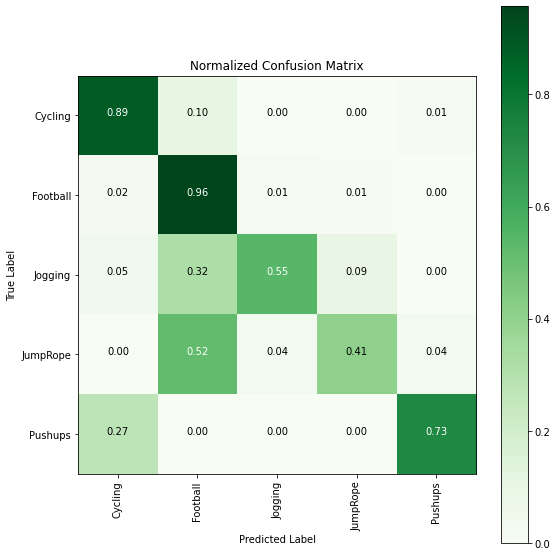

-----------------------------
|   Classification Report   |
-----------------------------
              precision    recall  f1-score   support

     Cycling       0.90      0.89      0.90       188
    Football       0.93      0.96      0.94       559
     Jogging       0.57      0.55      0.56        22
    JumpRope       0.65      0.41      0.50        27
     Pushups       0.80      0.73      0.76        22

    accuracy                           0.91       818
   macro avg       0.77      0.71      0.73       818
weighted avg       0.90      0.91      0.90       818



In [17]:
best_kernel_svm = svm.SVC(kernel='rbf', C=90, gamma='scale')
best_svm_results = perform_model(best_kernel_svm, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
# pca = PCA() # By default, PCA() centers the data, but does not scale it.
# X_train_pca = pca.fit_transform(X_train)

# per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
# labels = [str(x) for x in range(1, len(per_var)+1)]

# plt.bar(x=range(1, len(per_var)+1), height=per_var)
# plt.tick_params(
#     axis='x',
#     which='both',
#     bottom=False,
#     top=False,
#     labelbottom=False)
# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Components')
# plt.ylim([0,10])
# plt.title('Scree Plot')
# plt.show()

In [ ]:
# train_pc1_coords = X_train_pca[:, 0]
# train_pc2_coords = X_train_pca[:, 1]

# pca_train = np.column_stack((train_pc1_coords,train_pc2_coords))

# param_grid = [
#     {'C': [1, 10, 100, 1000],
#      'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
#      'kernel': ['rbf']},
# ]

# optimal_params = GridSearchCV(
#         svm.SVC(),
#         param_grid,
#         cv=5,
#         scoring='accuracy',
#         n_jobs=-1,
#         verbose=1)

# optimal_params.fit(pca_train, y_train)

In [ ]:
# print(optimal_params.best_params_)

## Decision Trees

## Logistic Regression

In [ ]:
# reg_params = {'C':[0.001, 0.125, 0.5, 1, 8, 16, 50], 'class_weight':['balanced',None], 
#               'solver':[ 'newton-cg', 'sag', 'saga', 'lbfgs'], 'multi_class':['ovr', 'multinomial']} acc : 96.26%
# reg_params = {'C':[ 9, 10, 11, 14], 'class_weight':['balanced'], 
#               'solver':[ 'lbfgs'], 'multi_class':['ovr', ' multinomial']} acc : 96.3%
reg_params = {'C':[ 9, 10, 11, 14], 'class_weight':['balanced'], 'solver':[ 'lbfgs'], 'multi_class':['ovr'],
              'penalty': ['l1','l2','elasticnet','none']}
reg_kernel = linear_model.LogisticRegression()
reg_grid = GridSearchCV(reg_kernel, param_grid=reg_params, n_jobs=-1, verbose=1)
reg_grid_results = perform_model(reg_grid, X_train, y_train, X_test, y_test,class_labels=labels)

In [ ]:
print_grid_search_attributes(reg_grid_results['model'])

In [ ]:
best_kernel_reg = linear_model.LogisticRegression(C=10, penalty='l2', class_weight='balanced', solver='lbfgs', multi_class='ovr', max_iter=200)
best_reg_results = perform_model(best_kernel_reg, X_train, y_train, X_test, y_test,class_labels=labels)